# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import requests

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.metrics import accuracy_score
import math 

In [2]:
#ng_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\natural gas\\Total_consumption_natural_gas_Alaska_all_commercial_(total)_monthly.csv")
ng_data=pd.read_csv("Total_consumption_natural_gas_Alaska_all_commercial_(total)_monthly.csv")
ng_data=ng_data.rename(columns={'Series ID: ELEC.CONS_TOT.NG-AK-96.M thousand Mcf':'Ng_Con'})
mean_values = (ng_data['Ng_Con'].shift() + ng_data['Ng_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ng_data['Ng_Con'].fillna(mean_values, inplace=True)
ng_data['D'] = ng_data['Month'].str.slice(0, 2)
ng_data['M'] = ng_data['Month'].str.slice(3, 5)
ng_data['Y'] = ng_data['Month'].str.slice(6, 10)
ng_data['Date1'] = ng_data['Y']+'-'+ng_data['M']+'-'+ng_data['D']
ng_data['Date'] = pd.to_datetime(ng_data['Date1'])
ng_data3=ng_data.sort_values(['Date'],ascending=True)
ng_data4=ng_data3[['Date','Ng_Con']]
ng_data4

,Date,Ng_Con
0,2007-01-01,0.000
1,2007-02-01,0.000
2,2007-03-01,0.000
3,2007-04-01,0.000
4,2007-05-01,0.000
...,...,...
184,2022-05-01,1.106
185,2022-06-01,0.001
186,2022-07-01,0.015
187,2022-08-01,0.224


In [3]:
#libaries for time series
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMA
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 

<AxesSubplot:xlabel='Date'>

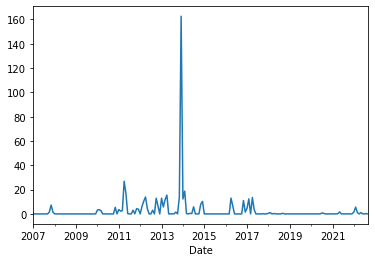

In [4]:
# dataset creation
#coal_data4=coal_data3.copy()
df = ng_data4.set_index("Date")
df['Ng_Con'].plot(style="-")

In [5]:
y=df['Ng_Con']
y_to_val = y['2018-12-01':] # dataset to train
y_to_train = y[:'2018-12-01'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


# Seasonal Naive Forecast model

In [6]:
def pysnaive(train_series,seasonal_periods,forecast_horizon):
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=np.int(np.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=np.tile(last_season,reps)
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast

In [7]:
import mlflow
import pandas as pd
import pmdarima as pm
# from fbprophet import Prophet
from prophet import Prophet
import matplotlib.pyplot as plt

# Set up mlflow tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("forecasting-model-natural-gas")
mlflow.tensorflow.autolog()

2023-02-25 22:56:33.680183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023/02/25 22:56:36 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Cmd('git') failed due to: exit code(1)
  cmdline: git version
  stderr: 'xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun'


Mean Absolute error is 3.4515208333333334
MAPE is inf
RMSE is 14.48702914894907


2023/02/25 22:56:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


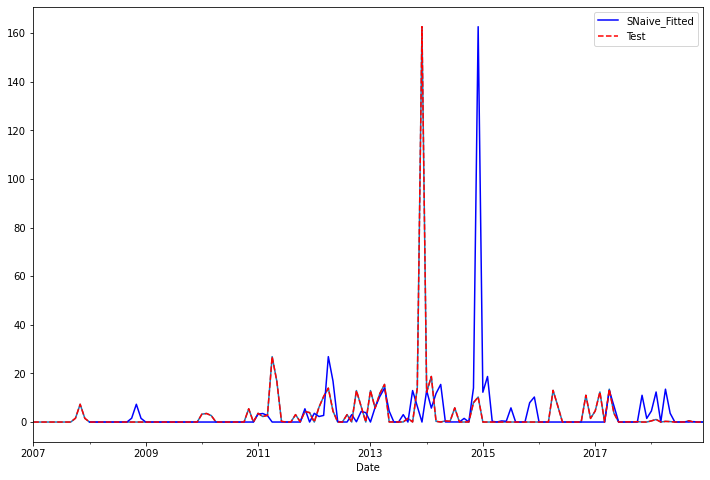

In [8]:
# Start mlflow run
with mlflow.start_run():
    #Fitted values
    py_snaive_fit = pysnaive(train["Ng_Con"], 
                         seasonal_periods=12,
                         forecast_horizon=len(train))[0]

    #forecast
    py_snaive = pysnaive(train["Ng_Con"], 
                         seasonal_periods=12,
                         forecast_horizon=len(train))[1]

    #Residuals
    py_snaive_resid = (train["Ng_Con"] - py_snaive_fit).dropna()



    predictions=train.copy()
    predictions["py_snaive"] = py_snaive.values 


    predictions

    # Charting the output
    pd.plotting.register_matplotlib_converters()
    fig = plt.figure(figsize=(10,5))
    train["Ng_Con"].plot(figsize=(12,8))#, style="--", color="gray", legend=True, label="Train")
    py_snaive_fit.plot(color="b", legend=True, label="SNaive_Fitted")
    predictions["Ng_Con"].plot(style="--",color="r", legend=True, label="Test")
    #predictions["py_snaive"].plot(color="b", legend=True, label="Snaive_fc");


    #MAE
    n=mean_absolute_error(predictions["Ng_Con"], predictions["py_snaive"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((predictions["Ng_Con"] - predictions["py_snaive"]) / predictions["Ng_Con"])) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(predictions["Ng_Con"], predictions["py_snaive"]))
    print("RMSE is",r)

    # Log model parameters and metrics to mlflow
    mlflow.log_param("model", "py_snaive")
    #mlflow.set_tag("model", py_snaive_fit)
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "Seasonal-Naive.png")
    
    
    # Save model as artifact
    mlflow.sklearn.log_model(py_snaive_fit, "model")

In [9]:
if (train["Ng_Con"] <= 0).any().any():
    # replace negative and zero values with positive values
    train["Ng_Con"] = train["Ng_Con"].apply(lambda x: abs(x) + 0.01 if x <= 0 else x)
print(train)

            Ng_Con
Date              
2007-01-01   0.010
2007-02-01   0.010
2007-03-01   0.010
2007-04-01   0.010
2007-05-01   0.010
...            ...
2018-08-01   0.010
2018-09-01   0.518
2018-10-01   0.007
2018-11-01   0.013
2018-12-01   0.010

[144 rows x 1 columns]


# Holt-Winter's Method

Mean Absolute error is 0.8238833608519617
MAPE is inf
RMSE is 1.360440657535947


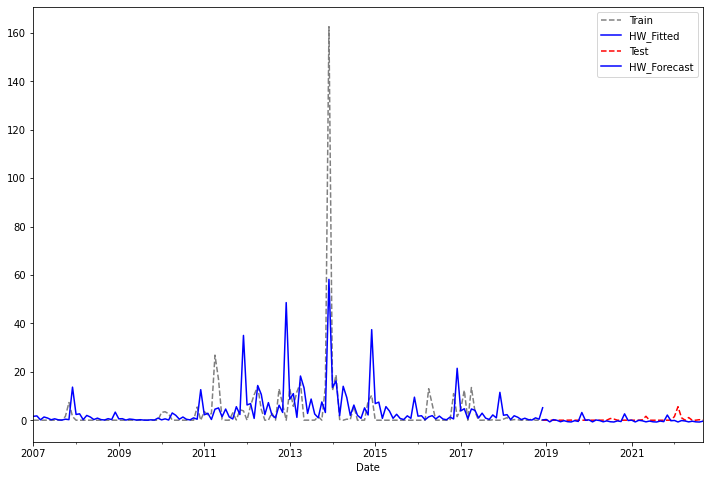

In [10]:
with mlflow.start_run():
    hw_model = ExponentialSmoothing(train["Ng_Con"],
                              trend    ="mul",
                              seasonal = "mul", 
                              seasonal_periods=12).fit()

    hw_fitted = hw_model.fittedvalues

    hw_resid = hw_model.resid

    #Adding the mean of the residuals to correct the bias.
    py_hw = hw_model.forecast(len(test["Ng_Con"]))+np.mean(hw_resid)
    py_hw=pd.DataFrame(py_hw)
    py_hw.columns=['py_hw']
    py_hw=py_hw.reset_index()
    py_hw=py_hw.drop('index',axis=1)
    predictions1=test.copy()
    predictions1=predictions1.reset_index()
    py_hw2 = pd.concat([predictions1,py_hw],axis=1)
    py_hw2=py_hw2.set_index('Date')
    py_hw2


    fig = plt.figure(figsize=(10,5))
    train["Ng_Con"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
    hw_fitted.plot(color="b", legend=True, label="HW_Fitted")
    py_hw2["Ng_Con"].plot(style="--",color="r", legend=True, label="Test")
    py_hw2["py_hw"].plot(color="b", legend=True, label="HW_Forecast")

    #MAE
    n=mean_absolute_error(py_hw2.Ng_Con, py_hw2["py_hw"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((py_hw2.Ng_Con - py_hw2["py_hw"]) / py_hw2.Ng_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(py_hw2.Ng_Con, py_hw2["py_hw"]))
    print("RMSE is",r)
    mlflow.log_param("model", "Holt-Winter")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "Holt-winter.png")
    # Save model as artifact
    mlflow.sklearn.log_model(hw_model, "model")

# ETS Model

In [11]:
#ng_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\natural gas\\Total_consumption_natural_gas_Alaska_all_commercial_(total)_monthly.csv")
ng_data=pd.read_csv("Total_consumption_natural_gas_Alaska_all_commercial_(total)_monthly.csv")
ng_data=ng_data.rename(columns={'Series ID: ELEC.CONS_TOT.NG-AK-96.M thousand Mcf':'Ng_Con'})
mean_values = (ng_data['Ng_Con'].shift() + ng_data['Ng_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ng_data['Ng_Con'].fillna(mean_values, inplace=True)
ng_data['D'] = ng_data['Month'].str.slice(0, 2)
ng_data['M'] = ng_data['Month'].str.slice(3, 5)
ng_data['Y'] = ng_data['Month'].str.slice(6, 10)
ng_data['Date1'] = ng_data['Y']+'-'+ng_data['M']+'-'+ng_data['D']
ng_data['Date'] = pd.to_datetime(ng_data['Date1'])
ng_data3=ng_data.sort_values(['Date'],ascending=True)
ng_data4=ng_data3[['Month','Ng_Con']]
df = ng_data4.set_index("Month")
y=df['Ng_Con']
y_to_val = y['01-12-2018':] # dataset to train
y_to_train = y[:'01-12-2018'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06146D+00    |proj g|=  2.33649D-02


 This problem is unconstrained.



At iterate    5    f=  4.02690D+00    |proj g|=  6.09457D-04

At iterate   10    f=  4.01969D+00    |proj g|=  4.89278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   9.238D-06   4.020D+00
  F =   4.0196488172833700     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Mean Absolute error is 4.05221819490151
MAPE is inf
RMSE is 5.518045059666766


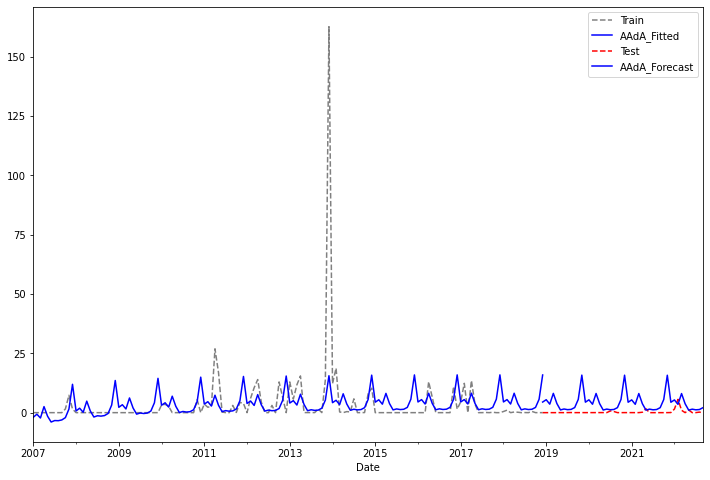

In [12]:
with mlflow.start_run():

    ets_AAdA=sm.tsa.statespace.ExponentialSmoothing(train["Ng_Con"],
                                               trend=True, 
                                               initialization_method= 'concentrated', 
                                               seasonal=12, 
                                               damped_trend=True).fit()

    fc_AAdA=ets_AAdA.forecast(len(test))

    fc_AAdA=pd.DataFrame(fc_AAdA)
    fc_AAdA.columns=['fc_AAdA']
    fc_AAdA=fc_AAdA.reset_index()
    fc_AAdA=fc_AAdA.drop('index',axis=1)
    predictions2=test.copy()
    predictions2=predictions2.reset_index()
    fc_AAdA2 = pd.concat([predictions2,fc_AAdA],axis=1)
    fc_AAdA2=fc_AAdA2.set_index('Month')
    fc_AAdA2=fc_AAdA2.reset_index()
    fc_AAdA2['D'] = fc_AAdA2['Month'].str.slice(0, 2)
    fc_AAdA2['M'] = fc_AAdA2['Month'].str.slice(3, 5)
    fc_AAdA2['Y'] = fc_AAdA2['Month'].str.slice(6, 10)
    fc_AAdA2['Date1'] = fc_AAdA2['Y']+'-'+fc_AAdA2['M']+'-'+fc_AAdA2['D']
    fc_AAdA2['Date'] = pd.to_datetime(fc_AAdA2['Date1'])
    fc_AAdA2=fc_AAdA2[['Date','Ng_Con','fc_AAdA']]
    fc_AAdA2=fc_AAdA2.set_index('Date')
    fc_AAdA2

    ets_AAdA2=pd.DataFrame(ets_AAdA.fittedvalues)
    ets_AAdA2=ets_AAdA2.reset_index()
    ets_AAdA2['D'] = ets_AAdA2['Month'].str.slice(0, 2)
    ets_AAdA2['M'] = ets_AAdA2['Month'].str.slice(3, 5)
    ets_AAdA2['Y'] = ets_AAdA2['Month'].str.slice(6, 10)
    ets_AAdA2['Date1'] = ets_AAdA2['Y']+'-'+ets_AAdA2['M']+'-'+ets_AAdA2['D']
    ets_AAdA2['Date'] = pd.to_datetime(ets_AAdA2['Date1'])
    ets_AAdA2=ets_AAdA2[['Date',0]]
    ets_AAdA2=ets_AAdA2.set_index('Date')
    ets_AAdA2

    train2=train.reset_index()
    train2['D'] = train2['Month'].str.slice(0, 2)
    train2['M'] = train2['Month'].str.slice(3, 5)
    train2['Y'] = train2['Month'].str.slice(6, 10)
    train2['Date1'] = train2['Y']+'-'+train2['M']+'-'+train2['D']
    train2['Date'] = pd.to_datetime(train2['Date1'])
    train2=train2[['Date','Ng_Con']]
    train2=train2.set_index('Date')
    train2

    #Plotting
    fig = plt.figure(figsize=(10,5))
    train2["Ng_Con"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
    ets_AAdA2[0].plot(color="b", legend=True, label="AAdA_Fitted")
    fc_AAdA2["Ng_Con"].plot(style="--",color="r", legend=True, label="Test")
    fc_AAdA2["fc_AAdA"].plot(color="b", legend=True, label="AAdA_Forecast")

    #MAE
    n=mean_absolute_error(fc_AAdA2.Ng_Con, fc_AAdA2["fc_AAdA"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((fc_AAdA2.Ng_Con - fc_AAdA2["fc_AAdA"]) / fc_AAdA2.Ng_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(fc_AAdA2.Ng_Con, fc_AAdA2["fc_AAdA"]))
    print("RMSE is",r)

    mlflow.log_param("model", "ETS")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "my-plot.png")
    # Save model as artifact
    mlflow.sklearn.log_model(ets_AAdA, "model")

# SARIMA

In [13]:
#ng_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\natural gas\\Total_consumption_natural_gas_Alaska_all_commercial_(total)_monthly.csv")
ng_data=pd.read_csv("Total_consumption_natural_gas_Alaska_all_commercial_(total)_monthly.csv")
ng_data=ng_data.rename(columns={'Series ID: ELEC.CONS_TOT.NG-AK-96.M thousand Mcf':'Ng_Con'})
mean_values = (ng_data['Ng_Con'].shift() + ng_data['Ng_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ng_data['Ng_Con'].fillna(mean_values, inplace=True)
ng_data['D'] = ng_data['Month'].str.slice(0, 2)
ng_data['M'] = ng_data['Month'].str.slice(3, 5)
ng_data['Y'] = ng_data['Month'].str.slice(6, 10)
ng_data['Date1'] = ng_data['Y']+'-'+ng_data['M']+'-'+ng_data['D']
ng_data['Date'] = pd.to_datetime(ng_data['Date1'])
ng_data3=ng_data.sort_values(['Date'],ascending=True)
ng_data4=ng_data3[['Date','Ng_Con']]
df = ng_data4.set_index("Date")
y=df['Ng_Con']
y_to_val = y['2018-12-01':] # dataset to train
y_to_train = y[:'2018-12-01'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


In [14]:
# determining the parameters
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
               
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

sarima_grid_search(y,12)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94158D+00    |proj g|=  4.16827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   4.396D-06   3.942D+00
  F =   3.9415684675545206     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.53795D+00    |proj g|=  1.11861D-01

At iterate   10    f=  3.51363D+00    |proj g|=  6.34463D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     15      1     0     0   2.875D-07   3.514D+00
  F =   3.5136240422858829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73269D+00    |proj g|=  4.74225D-06

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65976D+00    |proj g|=  5.58789D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.588D-06   3.660D+00
  F =   3.6597625940488201     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90702D+00    |proj g|=  1.99563D-02

At iterate    5    f=  3.90684D+00    |proj g|=  4.22398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     12      1     0     0   1.672D-06   3.907D+00
  F =   3.9068249083609130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55887D+00    |proj g|=  1.04812D-01

At iterate    5    f=  3.52544D+00    |proj g|=  1.01782D-01

At iterate   10    f=  3.48554D+00    |proj g|=  8.75889D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   2.084D-06   3.486D+00
  F =   3.4855392556783116     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72109D+00    |proj g|=  3.85996D-02

At iterate    5    f=  3.71999D+00    |proj g|=  5.88929D-03

At iterate   10    f=  3.71983D+00    |proj g|=  1.22049D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   1.220D-06   3.720D+00
  F =   3.7198312212334743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  3.65781D+00    |proj g|=  4.99717D-02

At iterate   10    f=  3.65227D+00    |proj g|=  3.83827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   3.585D-06   3.652D+00
  F =   3.6522720363117318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56721D+00    |proj g|=  9.25902D-02


 This problem is unconstrained.



At iterate    5    f=  3.54350D+00    |proj g|=  6.29962D-02

At iterate   10    f=  3.48585D+00    |proj g|=  2.86181D-02

At iterate   15    f=  3.48554D+00    |proj g|=  1.95784D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   1.958D-05   3.486D+00
  F =   3.4855391871943362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.15549D+00    |proj g|=  6.59317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   3.783D-06   4.155D+00
  F =   4.1554618639685739     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.9

 This problem is unconstrained.


At iterate    5    f=  3.73493D+00    |proj g|=  1.12779D-01

At iterate   10    f=  3.71849D+00    |proj g|=  1.20015D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     16      1     0     0   1.200D-06   3.718D+00
  F =   3.7184908546428086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93848D+00    |proj g|=  4.65965D-06

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92426D+00    |proj g|=  3.71751D-02

At iterate    5    f=  3.91874D+00    |proj g|=  5.82343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     12      1     0     0   3.824D-06   3.919D+00
  F =   3.9187371727932940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.76400D+00    |proj g|=  4.63369D-02

At iterate   10    f=  3.71845D+00    |proj g|=  2.65118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     30      1     0     0   3.871D-05   3.718D+00
  F =   3.7184497005183155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94340D+00    |proj g|=  1.95438D-01

At iterate    5    f=  3.89389D+00    |proj g|=  1.19584D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01923D+00    |proj g|=  1.95668D-01

At iterate    5    f=  3.97081D+00    |proj g|=  2.68062D-02

At iterate   10    f=  3.96281D+00    |proj g|=  2.17119D-01

At iterate   15    f=  3.95970D+00    |proj g|=  3.84239D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     23      1     0     0   3.842D-06   3.960D+00
  F =   3.9596987722212629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75594D+00    |proj g|=  1.94073D-01

At iterate    5    f=  3.70648D+00    |proj g|=  4.00038D-02

At iterate   10    f=  3.70554D+00    |proj g|=  6.34897D-02

At iterate   15    f=  3.70236D+00    |proj g|=  7.11763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   2.498D-06   3.702D+00
  F =   3.7023533847497760     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate   10    f=  3.67829D+00    |proj g|=  6.37584D-02

At iterate   15    f=  3.65418D+00    |proj g|=  2.04812D-02

At iterate   20    f=  3.65370D+00    |proj g|=  3.37865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     30      1     0     0   3.379D-05   3.654D+00
  F =   3.6537045333407727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63500D+00    |proj g|=  1.14881D-01

At iterate    5    f=  3.57639D+00    |proj g|=  4.05825D-01
  ys=-4.204E-02  -gs= 7.749E-03 BFGS update SKIPPED

At iterate   10    f=  3.57323D+00    |proj g|=  4.29137D-02

At iterate   15    f=  3.52532D+00    |proj g|=  1.69818D-01

At iterate   20    f=  3.47856D+00    |proj g|=  3.28098D-01

At iterate   25    f=  3.47830D+00    |proj g|=  2.29599D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.69929D+00    |proj g|=  1.48973D-02

At iterate   10    f=  3.69881D+00    |proj g|=  1.15746D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   1.360D-06   3.699D+00
  F =   3.6988053840569886     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98521D+00    |proj g|=  4.69447D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70635D+00    |proj g|=  3.22765D-02

At iterate    5    f=  3.70035D+00    |proj g|=  3.95553D-02

At iterate   10    f=  3.69871D+00    |proj g|=  5.50098D-03

At iterate   15    f=  3.69848D+00    |proj g|=  1.82264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   9.454D-06   3.698D+00
  F =   3.6984840982526026     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63986D+00    |proj g|=  3.61476D-02

At iterate    5    f=  3.63252D+00    |proj g|=  3.41529D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   1.278D-06   3.632D+00
  F =   3.6316552531236748     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89886D+00    |proj g|=  5.83708D-03

At iterate    5    f=  3.89878D+00    |proj g|=  1.36318D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     12      1     0     0   1.625D-08   3.899D+00
  F =   3.8987761678938111     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.53519D+00    |proj g|=  5.60589D-02

At iterate   10    f=  3.48224D+00    |proj g|=  2.65060D-02

At iterate   15    f=  3.48199D+00    |proj g|=  2.84040D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   1.105D-05   3.482D+00
  F =   3.4819943984219637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69696D+00    |proj g|=  4.89638D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.67705D+00    |proj g|=  2.44324D-03

At iterate   10    f=  3.67680D+00    |proj g|=  1.62096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   7.359D-06   3.677D+00
  F =   3.6767923328330459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64055D+00    |proj g|=  3.93641D-02

At iterate    5    f=  3.63836D+00    |proj g|=  2.24921D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  3.63083D+00    |proj g|=  6.76209D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   5.728D-06   3.631D+00
  F =   3.6307949323216140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56581D+00    |proj g|=  9.39244D-02


 This problem is unconstrained.



At iterate    5    f=  3.54320D+00    |proj g|=  2.04433D-02

At iterate   10    f=  3.48931D+00    |proj g|=  4.04573D-01

At iterate   15    f=  3.48200D+00    |proj g|=  1.67075D-03

At iterate   20    f=  3.48199D+00    |proj g|=  8.56359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   5.788D-05   3.482D+00
  F =   3.4819935115120804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.67404D+00    |proj g|=  5.92465D-02

At iterate   10    f=  3.61710D+00    |proj g|=  8.14896D-02

At iterate   15    f=  3.61418D+00    |proj g|=  1.72484D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   1.725D-07   3.614D+00
  F =   3.6141812070808452     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80954D+00    |proj g|=  2.30103D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   8.337D-07   3.808D+00
  F =   3.8082886765587101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81142D+00    |proj g|=  6.72847D-02

At iterate    5    f=  3.80866D+00    |proj g|=  1.32728D-02

At iterate   10    f=  3.80829D+00    |proj g|=  7.77342D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.75036D+00    |proj g|=  3.56639D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   2.543D-06   3.750D+00
  F =   3.7496883102747063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71945D+00    |proj g|=  6.24628D-02

At iterate    5    f=  3.67962D+00    |proj g|=  5.48899D-02

At iterate   10    f=  3.66739D+00    |proj g|=  2.12156D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72023D+00    |proj g|=  1.93537D-01

At iterate    5    f=  3.66244D+00    |proj g|=  1.73714D-02

At iterate   10    f=  3.65922D+00    |proj g|=  5.12934D-02

At iterate   15    f=  3.65810D+00    |proj g|=  9.15805D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   9.158D-06   3.658D+00
  F =   3.6581009908431854     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  3.96708D+00    |proj g|=  9.47699D-03

At iterate   10    f=  3.95580D+00    |proj g|=  2.54659D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     20      1     0     0   3.373D-07   3.956D+00
  F =   3.9557989751857749     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60588D+00    |proj g|=  9.99765D-02


 This problem is unconstrained.



At iterate    5    f=  3.57735D+00    |proj g|=  1.12919D-01

At iterate   10    f=  3.53820D+00    |proj g|=  1.52773D-01

At iterate   15    f=  3.47334D+00    |proj g|=  1.26512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   6.460D-06   3.473D+00
  F =   3.4733373206646481     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73695D+00    |proj g|=  1.94715D-01

At iterate    5    f=  3.68142D+00    |proj g|=  1.67674D-02

At iterate   10    f=  3.67801D+00    |proj g|=  3.98819D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   5.048D-05   3.677D+00
  F =   3.6766146056833935     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  3.65909D+00    |proj g|=  4.46422D-02

At iterate   10    f=  3.65602D+00    |proj g|=  3.29115D-02

At iterate   15    f=  3.62851D+00    |proj g|=  1.09382D-01

At iterate   20    f=  3.62342D+00    |proj g|=  3.44801D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   3.426D-07   3.623D+00
  F =   3.6234180949672075     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  3.57562D+00    |proj g|=  1.57484D-01

At iterate   10    f=  3.57194D+00    |proj g|=  7.69981D-02

At iterate   15    f=  3.50012D+00    |proj g|=  1.68765D-01

At iterate   20    f=  3.47377D+00    |proj g|=  4.14577D-02

At iterate   25    f=  3.47334D+00    |proj g|=  6.57820D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     39      1     0     0   6.578D-06   3.473D+00
  F =   3.4733364125932660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:1320.7974924490545


In [15]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    k=mean_absolute_error(y_forecasted, y_to_test)
    n=np.mean(np.abs((y_to_test - y_forecasted) / y_to_test)) * 100
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print("Mean Absolute error :",k)
    print("MAPE is :",n)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    k_dynamic=mean_absolute_error(y_forecasted_dynamic, y_to_test)
    n_dynamic=np.mean(np.abs((y_to_test - y_forecasted_dynamic) / y_to_test)) * 100
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print("Mean Absolute error :",k_dynamic)
    print("MAPE is :",n_dynamic)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))
    fig = plt.figure(figsize=(10,5))
    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    with mlflow.start_run():
        #log the params
        mlflow.log_param("model", "SARIMA")
        #log the metrics
        mlflow.log_metric("mae", k_dynamic)
        mlflow.log_metric("mape", n_dynamic)
        mlflow.log_metric("rmse", r)
        #log the plot
        mlflow.log_figure(fig, "SARIMA.png")
        # Save model as artifact
        mlflow.pmdarima.log_model(results, "model")    
    
    return (results)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60385D+00    |proj g|=  1.04908D-01

At iterate    5    f=  3.57836D+00    |proj g|=  2.48420D-02


 This problem is unconstrained.



At iterate   10    f=  3.48224D+00    |proj g|=  8.47675D-02

At iterate   15    f=  3.47830D+00    |proj g|=  5.65111D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     25      1     0     0   1.026D-06   3.478D+00
  F =   3.4783002445742182     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9353      0.053    -17.748      0.000      -1.039      -0.832
ma.S.L12      -1.0000   1672.694     -0.001      1.000   -3279

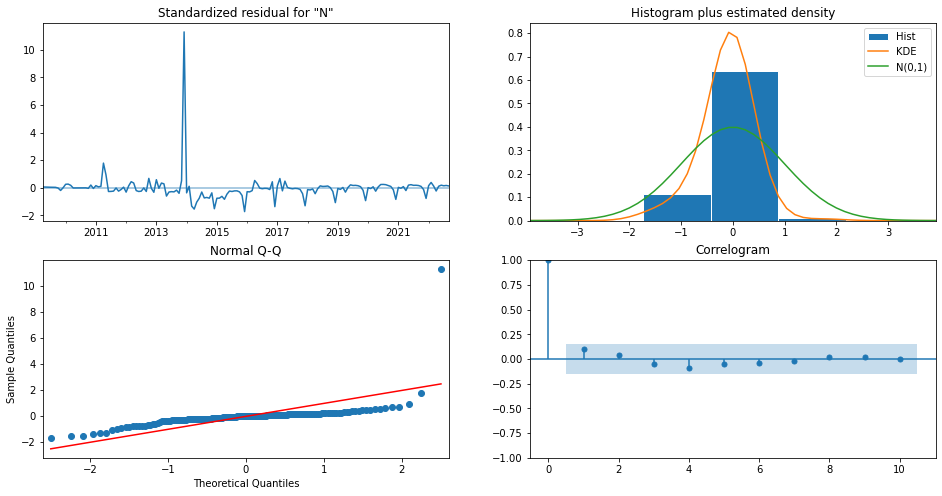

Mean Absolute error : 2.851300330429638
MAPE is : inf
The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 4.23


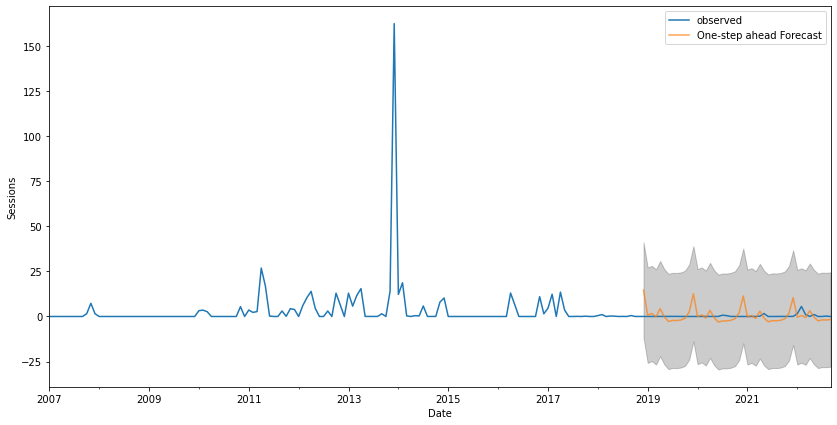

Mean Absolute error : 2.8747732284759024
MAPE is : inf
The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 4.89


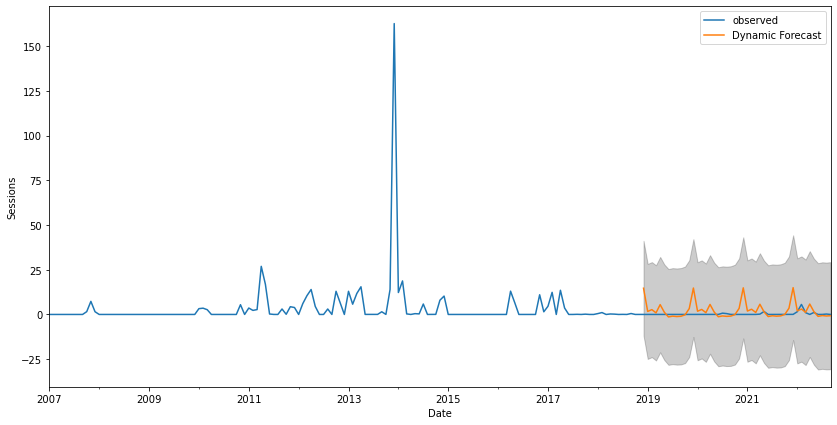

In [16]:
model = sarima_eva(y,(0, 1, 1),(0, 1, 1, 12),12,'2018-12-01',y_to_val)

In [17]:
# price forecasting
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)
    pred_ci = pred_uc.conf_int()
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    
    
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    
    pci2=pci.set_index('Date')
    pm2=pm.set_index('Date')
    ax = y.plot(label='observed', figsize=(14, 7))
    pm2.plot(ax=ax, label='Forecast')
    ax.fill_between(pci2.index,
                    pci2.iloc[:, 0],
                    pci2.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()

    final_table = pm.join(pci.set_index('Date'), on='Date')
    final_table=final_table.set_index('Date')
    return (final_table)

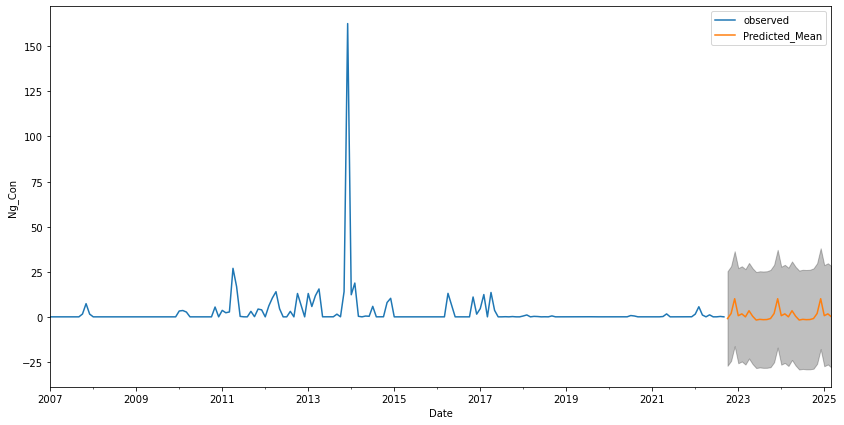

In [18]:
forecast_table=forecast(model,30,y)

In [19]:
forecast_table.to_csv('forecast_naturalgas_values.csv')